# Working with satellites

## License

```
Working with the satellites module of pycraf.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

Note: GitHub's integrated notebook viewer won't show the embedded videos. You can use the [nbviewer](http://nbviewer.jupyter.org/) service to open the notebook. Or follow the direct [link](http://nbviewer.jupyter.org/github/bwinkel/pycraf/blob/master/notebooks/04a_satellites_plot.ipynb).

In [1]:
%matplotlib inline

In [8]:
import requests
import datetime
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

from astropy import time
from astropy import units as u
from astropy.coordinates import EarthLocation
from pycraf import satellite

rc('animation', html='html5')

## Two-line elements sets (TLE)

To compute positions of a satellite, two-line element sets (TLE) have to be used. These look like the following

    ISS (ZARYA)
    1 25544U 98067A   13165.59097222  .00004759  00000-0  88814-4 0    47
    2 25544  51.6478 121.2152 0011003  68.5125 263.9959 15.50783143834295

which is the latest TLE for the international space station. The first line has only the name (or identifier) of a satellite. The following two lines contain all the necessary information about the satellite orbit to calculate its position for a certain time. Note that the TLEs are usually published once a day, because the contained parameters quickly change; drag forces cause rapid changes in the orbits of almost all satellites.

Of course, the position of a satellite depends on the choosen coordinate system. With the help of the [sgp4 package](https://pypi.python.org/pypi/sgp4/) pycraf calculates the ECI position of the satellite (in Cartesian coordinates). ECI is the [Earth-centered inertial frame](https://en.wikipedia.org/wiki/Earth-centered_inertial). But often we are interested in the apparent sky position (horizontal frame) of a satellite with respect to an observer. The latter is not provided by the `sgp4` library, but `pycraf` adds this functionality.

## Fetching latest satellites from Celestrak

As an example how to use the `pycraf.satellites` module, we will download the latest TLE data of all satellites launched in the last 30 days.

In [9]:
celestrak_latest = requests.get('http://celestrak.com/NORAD/elements/tle-new.txt')

In [10]:
celestrak_latest.text[:1000]

'APSTAR 6C               \r\n1 43450U 18041A   18150.59081966 -.00000321  00000-0  10000-3 0  9990\r\n2 43450   0.1188 267.6396 0001589 147.1402 180.1097  1.00275283   360\r\nCZ-3B R/B               \r\n1 43451U 18041B   18150.59600227  .00006377  00000-0  73754-3 0  9999\r\n2 43451  27.3335  92.4380 7541728 192.6311 109.1327  1.98292364   541\r\nMARCO-A                 \r\n1 43458U 18042B   18125.51663196 -.00002567  81162-5  00000-0 0  9997\r\n2 43458  63.9700 108.8000 0014000 352.2000  89.5396 16.35832554    07\r\nGAOFEN-5                \r\n1 43461U 18043A   18151.31945582  .00000010  00000-0  11983-4 0  9994\r\n2 43461  98.1249  92.6977 0001417 163.3119 196.8129 14.57764375  3301\r\nCZ-4C R/B               \r\n1 43462U 18043B   18150.64352039  .00000046  00000-0  13061-4 0  9997\r\n2 43462  98.1136  92.7772 0095944 325.9589  36.4859 14.80627680  3229\r\nBANGABANDHUSAT-1        \r\n1 43463U 18044A   18151.59439850 -.00000366  00000-0  00000+0 0  9991\r\n2 43463   0.0691 124.0838 00

The 'tle-new.txt' file apparently simply contains a list of TLEs. Let's fix the line endings (`\r\n` to `\n`) and split into a list of TLEs:

In [11]:
all_lines = celestrak_latest.text.split('\r\n')
tle_list = []
for idx in range(len(all_lines) // 3):
    tle_list.append('\n'.join(all_lines[3 * idx: 3 * (idx + 1)]))

In [13]:
print(tle_list[0])
print(tle_list[1])

APSTAR 6C               
1 43450U 18041A   18150.59081966 -.00000321  00000-0  10000-3 0  9990
2 43450   0.1188 267.6396 0001589 147.1402 180.1097  1.00275283   360
CZ-3B R/B               
1 43451U 18041B   18150.59600227  .00006377  00000-0  73754-3 0  9999
2 43451  27.3335  92.4380 7541728 192.6311 109.1327  1.98292364   541


## Plotting satellite position

Before we start plotting, we'll use have `sgp4` parse all the satellite strings and construct `sgp4.io.Satellite` instances. These merely contain the orbital parameters, but it will be faster to work the the already parsed data instead of letting the TLEs being parsed in each time step (yes, we are going to do a nice animation).

In [7]:
sat_list = [satellite.get_sat(tle_string) for tle_string in tle_list]
# contains a list of tuples: (sat_name, sat_instance)
sat_list[0]

ImportError: The "sgp4" package is necessary to use this function.

The second ingredient, we need is an array of "observing" times. pycraf wants an `astropy.time.Time` object for this, because it has (accurate!) built-in conversion between UTC and sidereal time.

In [14]:
start_time = time.Time(datetime.datetime.utcnow(), 'utc')
print('Start time:', start_time)
td = time.TimeDelta(np.arange(0, 3600 * 24, 60 * 1), format='sec')
times = start_time + td  # one day in steps of 1 min

Start time: 2018-05-31 19:40:06.728228


### ECI position
For this we make use of `sgp4` built-in `propagate` method. This is easy to use, but it doesn't work with numpy arrays. Let's vectorize it:

In [15]:
def _propagate(sat, dt):
    '''
    True equator mean equinox (TEME) position from `sgp4` at given time.
    Parameters
    ----------
    sat : `sgp4.io.Satellite` instance
        Satellite object filled from TLE
    dt : `~datetime.datetime`
        Time
    Returns
    -------
    xs, ys, zs : float
        TEME (=True equator mean equinox) position of satellite [km]
    '''

    # pos [km], vel [km/s]
    position, velocity = sat.propagate(
        dt.year, dt.month, dt.day,
        dt.hour, dt.minute, dt.second + dt.microsecond / 1e6
        )

    if position is None:
        raise ValueError('Satellite propagation error')

    return position


vec_propagate = np.vectorize(
    _propagate, excluded=['sat'], otypes=[np.float64] * 3
    )

In [16]:
pos_eci = np.array([vec_propagate(sat[1], times.datetime) for sat in sat_list])

NameError: name 'sat_list' is not defined

NameError: name 'pos_eci' is not defined

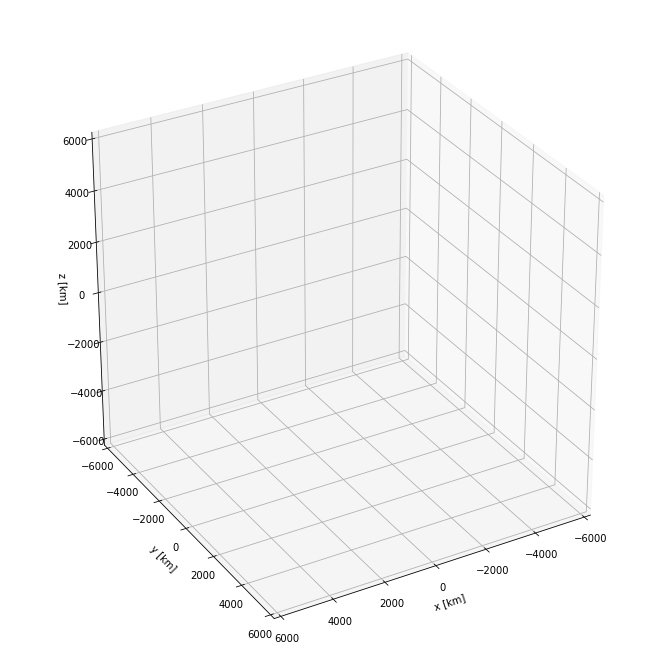

In [17]:
plim = 6000

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
ax.view_init(azim=60, elev=30)
ax.set_xlim((-plim, plim))
ax.set_ylim((-plim, plim))
ax.set_zlim((-plim, plim))
ax.set_aspect('equal')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

points = ax.scatter(pos_eci[:, 0, 0], pos_eci[:, 1, 0], pos_eci[:, 2, 0], marker='o')
title = ax.set_title('{:%y/%m/%d %H:%M}'.format(times[0].datetime), loc='center', fontsize=20)

def init():
    points._offsets3d = (pos_eci[:, 0, 0], pos_eci[:, 1, 0], pos_eci[:, 2, 0])
    title.set_text('{:%y/%m/%d %H:%M}'.format(times[0].datetime))
    return points, title

def animate(i):
    points._offsets3d = (pos_eci[:, 0, i], pos_eci[:, 1, i], pos_eci[:, 2, i])
    title.set_text('{:%y/%m/%d %H:%M}'.format(times[i].datetime))
    return points, title

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=pos_eci.shape[2], interval=20, blit=True
    )

# this takes a while!
plt.close(anim._fig)
anim

### Horizontal position

For the next plot, we need to define an observer position, say the famous Parkes 64-m dish and the Effelsberg 100-m radio telescope.

In [18]:
obs_loc_parkes = EarthLocation(148.25738, -32.9933, 414.8)
obs_loc_effbg = EarthLocation(6.88375, 50.525, 366.)

# create a SatelliteObserver instance
sat_obs_parkes = satellite.SatelliteObserver(obs_loc_parkes)
sat_obs_effbg = satellite.SatelliteObserver(obs_loc_effbg)
pos_horiz_parkes = np.array([
    sat_obs_parkes.azel_from_sat(sat[1], times)
    for sat in sat_list
    ])
pos_horiz_effbg = np.array([
    sat_obs_effbg.azel_from_sat(sat[1], times)
    for sat in sat_list
    ])


NameError: name 'sat_list' is not defined

NameError: name 'pos_horiz_parkes' is not defined

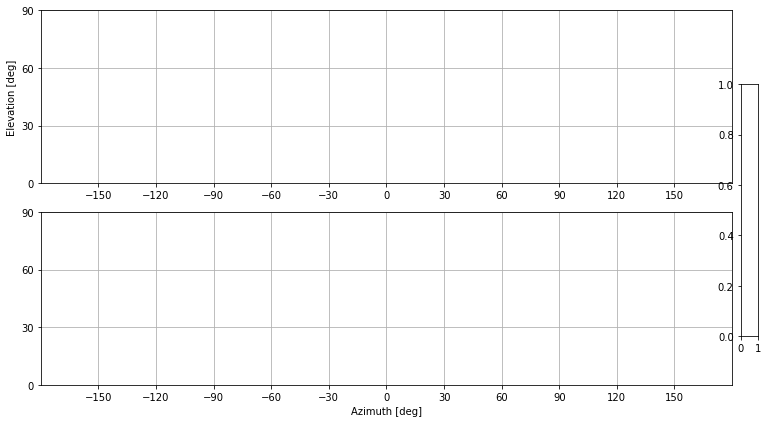

In [19]:
vmin, vmax = np.log10(100), np.log10(100000)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_axes((0.1, 0.5, 0.8, 0.35))
ax2 = fig.add_axes((0.1, 0.1, 0.8, 0.35))
cax = fig.add_axes((0.91, 0.2, 0.02, 0.5))
ax2.set_xlabel('Azimuth [deg]')
ax1.set_ylabel('Elevation [deg]')
for ax in [ax1, ax2]:
    ax.set_xlim((-180, 180))
    ax.set_ylim((0, 90))
    ax.set_xticks(range(-150, 180, 30))
    ax.set_yticks(range(0, 91, 30))
    ax.set_aspect('equal')
    ax.grid()

points1 = ax1.scatter(
    pos_horiz_parkes[:, 0, 0], pos_horiz_parkes[:, 1, 0],
    c=np.log10(pos_horiz_parkes[:, 2, 0]),
    cmap='viridis', vmin=vmin, vmax=vmax,
    )
points2 = ax2.scatter(
    pos_horiz_effbg[:, 0, 0], pos_horiz_effbg[:, 1, 0],
    c=np.log10(pos_horiz_effbg[:, 2, 0]),
    cmap='viridis', vmin=vmin, vmax=vmax,
    )
cbar = fig.colorbar(points1, cax=cax)
cbar.set_label('Distance (km)')
cbar.set_ticks([2, 3, 4, 5])
cbar.set_ticklabels([100, 1000, 10000, 100000])

ax1.text(-170, 75, 'Parkes 64-m', fontsize=16)
ax2.text(-170, 75, 'Effelsberg 100-m', fontsize=16)
title = ax1.text(
    174, 75, '{:%y/%m/%d %H:%M}'.format(times[0].datetime),
    fontsize=15, ha='right'
    )

def init():
    points1.set_offsets(pos_horiz_parkes[:, 0:2, 0])
    points1.set_array(np.log10(pos_horiz_parkes[:, 2, 0]))
    points2.set_offsets(pos_horiz_effbg[:, 0:2, 0])
    points2.set_array(np.log10(pos_horiz_effbg[:, 2, 0]))
    title.set_text('{:%y/%m/%d %H:%M}'.format(times[0].datetime))
    return points, title

def animate(i):
    points1.set_offsets(pos_horiz_parkes[:, 0:2, i])
    points1.set_array(np.log10(pos_horiz_parkes[:, 2, i]))
    points2.set_offsets(pos_horiz_effbg[:, 0:2, i])
    points2.set_array(np.log10(pos_horiz_effbg[:, 2, i]))
    title.set_text('{:%y/%m/%d %H:%M}'.format(times[i].datetime))
    return points, title

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=pos_horiz_parkes.shape[2], interval=20, blit=True
    )

# this takes a while!
plt.close(anim._fig)
anim